In [1]:
import librosa

PATH = "./song.mp3"

SAMPLE_RATE = 11025      # Sample rate for audio files (~11 kHz)

def load_song(file_path, sample_rate=SAMPLE_RATE):
    song, sr = librosa.load(file_path, sr=sample_rate, mono=True)
    return song, sr

song, sample_rate = load_song(PATH)
print(f"Song shape: {song.shape} samples")
print(f"Sample rate: {sample_rate} Hz")

Song shape: (3100320,) samples
Sample rate: 11025 Hz


In [2]:
WINDOW_SIZE = 1024
OVERLAP = 0.5

def frame_audio(audio, window_size=WINDOW_SIZE, overlap=OVERLAP):
    hop_length = int(window_size * (1 - overlap))
    frames = librosa.util.frame(audio, frame_length=window_size, hop_length=hop_length).T
    return frames

frames = frame_audio(song)
print(f"Number of frames: {frames.shape[0]}")
print(f"Frame size: {frames.shape[1]} samples")

Number of frames: 6054
Frame size: 1024 samples


A **Hanning (or Hann) window** is a smooth, bell-shaped function used in digital signal processing to reduce spectral leakage when analyzing signals, especially during Fourier Transforms (FFT). It works by gradually tapering signal data to zero at its edges, preventing abrupt discontinuities that cause energy from "leaking" into adjacent frequency bins, thereby improving the accuracy of frequency analysis, though with some trade-off in frequency resolution.

![Hanning Window](https://community.sw.siemens.com/servlet/rtaImage?eid=ka6KZ00000000iw&feoid=00N4O000006Yxpf&refid=0EM4O00000113sm)

In [3]:
import random
import numpy as np
import matplotlib.pyplot as plt

def compute_stft(signal, n_fft=WINDOW_SIZE, hop_length=int(WINDOW_SIZE*(1 - OVERLAP))):
    stft = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length, window="hann", center=False)
    return stft

stft = compute_stft(song)
print(f"STFT shape: {stft.shape}")

STFT shape: (513, 6054)


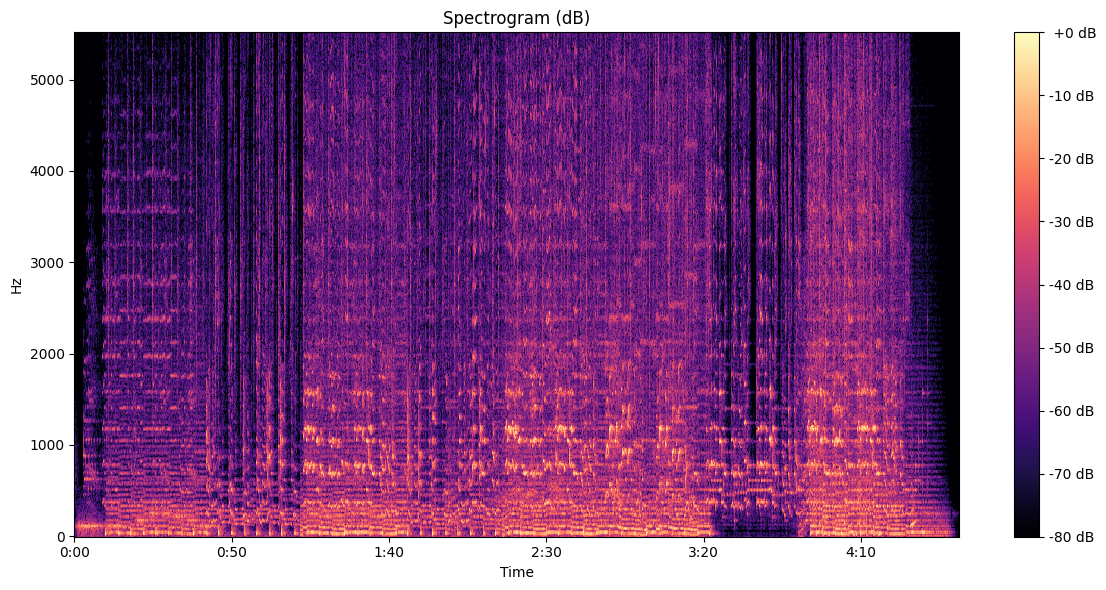

Spectrogram shape: (474, 6054)


In [4]:
FREQUENCY_START = 20        # 20 Hz
FREQUENCY_END = 5120        # 5.12 kHz

def plot_spectrogram(stft, sample_rate=SAMPLE_RATE, n_fft=WINDOW_SIZE, freq_start=FREQUENCY_START, freq_end=FREQUENCY_END, verbose=False):
    magnitude = np.abs(stft)
    db = librosa.amplitude_to_db(magnitude, ref=np.max)

    freqs = librosa.fft_frequencies(sr=sample_rate, n_fft=n_fft)
    
    # Filter frequencies between 20 Hz and 5.12 kHz
    mask = (freqs >= freq_start) & (freqs <= freq_end)      
    db = db[mask, :]
    
    if verbose:
        plt.figure(figsize=(12, 6))
        librosa.display.specshow(db, sr=sample_rate, x_axis="time", y_axis="linear", cmap="magma")
        plt.colorbar(format="%+3.0f dB")
        plt.title("Spectrogram (dB)")
        plt.tight_layout()
        plt.show()

    return db

I = plot_spectrogram(stft, verbose=True)
print(f"Spectrogram shape: {I.shape}")

In [5]:
bands = int(np.log2(FREQUENCY_END / FREQUENCY_START))

band_splits = [FREQUENCY_START]
for i in range(bands):
    band_splits.append(band_splits[-1] * 2)

print("Frequency band splits (Hz):", band_splits)

Frequency band splits (Hz): [20, 40, 80, 160, 320, 640, 1280, 2560, 5120]


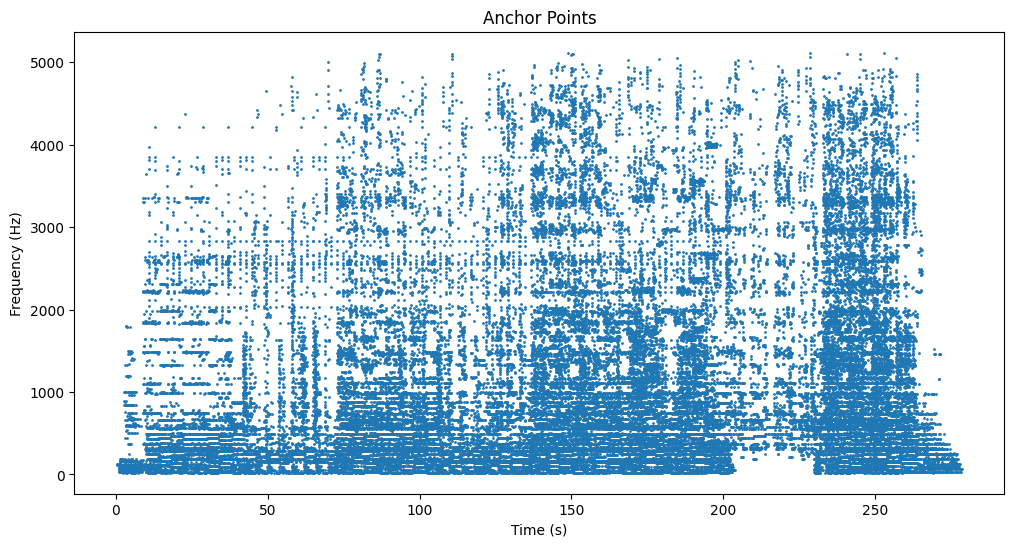

Number of peaks selected: 48,037


In [6]:
import scipy

KERNEL_SIZE = 3
THRESHOLD_INTENSITY = -40
K = 7

def select_peaks(spectrogram, sample_rate=SAMPLE_RATE, n_fft=WINDOW_SIZE, freq_start=FREQUENCY_START, freq_end=FREQUENCY_END, kernel_size=KERNEL_SIZE, threshold_intensity=THRESHOLD_INTENSITY, k=K, verbose=False):
    bands = int(np.log2(freq_end / freq_start))

    band_splits = [freq_start]
    for i in range(bands):
        band_splits.append(band_splits[-1] * 2)

    freqs = librosa.fft_frequencies(sr=sample_rate, n_fft=n_fft)
    freqs = freqs[(freqs >= freq_start) & (freqs <= freq_end)]

    peaks = []

    for start_freq, end_freq in zip(band_splits[:-1], band_splits[1:]):
        band_mask = (freqs >= start_freq) & (freqs < end_freq)
        
        band_indices = np.where(band_mask)[0]
        if len(band_indices) == 0:
            continue

        band_spectrogram = spectrogram[band_indices, :]

        maximas = scipy.ndimage.maximum_filter(band_spectrogram, size=(kernel_size, kernel_size), mode="constant", cval=-np.inf) == band_spectrogram
        band_peaks = np.argwhere(maximas)

        for time_idx in np.unique(band_peaks[:, 1]):
            time_peaks = band_peaks[band_peaks[:, 1] == time_idx]
            time_peaks = sorted(time_peaks, key=lambda x: band_spectrogram[x[0], x[1]], reverse=True)
            for time_peak in time_peaks[:k]:
                freq_idx, t_idx = time_peak
                magnitude = band_spectrogram[freq_idx, t_idx]
                if magnitude >= threshold_intensity:
                    peaks.append((band_indices[freq_idx], t_idx, magnitude))

    if verbose:
        hop_length = int(WINDOW_SIZE * (1 - OVERLAP))
        peak_times = [peak_time * hop_length / sample_rate for (freq_idx, peak_time, _) in peaks]
        peak_freqs = [freqs[freq_idx] for freq_idx, _, _ in peaks]

        plt.figure(figsize=(12, 6))
        plt.scatter(peak_times, peak_freqs, s=1)
        plt.xlabel("Time (s)")
        plt.ylabel("Frequency (Hz)")
        plt.title(f"Anchor Points")
        plt.show()

    return peaks

peaks = select_peaks(I, verbose=True)
print(f"Number of peaks selected: {len(peaks):,}")

In [7]:
def encode(f1, f2, dt):
    # 32-bit hash: [f1: 12 bits][f2: 12 bits][dt: 8 bits]
    return (f1 & 0xFFF) << 20 | (f2 & 0xFFF) << 8 | (dt & 0xFF)

TIME_INTERVAL = 2

def generate_hashes(peaks, hop_length=int(WINDOW_SIZE * (1 - OVERLAP)), time_interval=TIME_INTERVAL, sample_rate=SAMPLE_RATE):
    hashes = []

    peaks = sorted(peaks, key=lambda x: x[1])

    for ix, (f1_idx, t1_idx, _) in enumerate(peaks):
        t1 = t1_idx * hop_length / sample_rate
         
        for jx, (f2_idx, t2_idx, _) in enumerate(peaks[ix + 1:]):
            t2 = t2_idx * hop_length / sample_rate

            dt = t2 - t1
            if 0 < dt <= time_interval:
                dt = int(dt * 100)
                hash_value = encode(f1_idx, f2_idx, dt)
                hashes.append((int(hash_value), int(t1 * 1000)))
            else:
                break

    return hashes

hashes = generate_hashes(peaks)

n = len(hashes)
print(f"Number of hashes generated: {n:,}")

idx = random.randint(0, n - 1)
print(f"Sample hash {idx:,}: {hashes[idx]}")

Number of hashes generated: 2,034,661
Sample hash 978,186: (252707895, 152926)
